## [Lecture 12.3: ANN from scratch](https://www.youtube.com/watch?v=q1GTG13OgNY)

### Artificial Neural Networks
We begin by importing `numpy` and setting up a random number generator, `rng` with a seed value of 42. This random number generator will be used throughout the notebook to ensure reproducability of experiments.

In [1]:
import numpy as np
seed = 42
rng = np.random.default_rng(seed = seed)

### Network Class
We shall start writing the `Network` class. The two methods that are indespensable for any ML class are:
- `fit`
- `predict`

Fitting a neural network model requires us to compute two passes on the data:
- `forward`
- `backward`

We need to start at some place by initializing the network and various hyperparameters and this requires an `init` method:
- `init`

In most of these methods, we would have to take the help of certain helper functions:
- `activations`
- `losses`

This is the process. But we will work through it in the reverse order so that each step of the process does not have any forward references:

`helpers -> init -> forward -> backward -> fit -> predict`

The skeleton of the class is given in the code block that follows. For ease of exposition, we are going to discuss the methods one at a time and then plug them into the class right at the end.

In [2]:
class Network:

    def init(self, layers, activation_choice='relu', 
                           output_choice='softmax', 
                           loss_choice='cce'):
        pass

    def forward(self, X):
        pass

    def backward(self, X):
        pass

    def fit(self, X, Y, lr = 0.01,
                        epochs = 100,
                        batch_size = 100):
        pass

    def predict(self, X):
        pass


### Activation functions

#### Hidden Layer

We will look at two activation functions for hidden layers. Both these functions will be applied element-wise. The input to these functions can be scalars, vectors or matrices.

##### Sigmoid
$$
g(z) = \frac{1}{1 + e^{-z}}
$$

##### ReLU
This is a simple piecewise linear function.
$$
g(z) = \begin{cases}
    z, \quad z \ge 0 \\
    0, \quad z \lt 0
    \end{cases}
$$
We also need the derivatives of these functions while computing the backward pass. Deriving the mathematical expressions for them are left  as an exercise to the learners.

In [3]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def grad_sigmoid(z):
    return sigmoid(z) * (1 - sigmoid(z))

def relu(z):
    return np.where(z >=0, z, 0)

def grad_relu(z):
    return np.where(z >= 0, 1, 0)


# A dictionary of activation functions
# Will be used while initializing the network
hidden_act = {'sigmoid': sigmoid, 'relu': relu}
grad_hidden_act = {'sigmoid': grad_sigmoid, 'relu': grad_relu}

#### Output Layer
We will look at two activation  functions for the output layer. Identity for  regression and softmax for classification.
##### Identity
$$g(z) = z$$
##### Softmax
The input to the softmax function will always be the matrix of size $n \times k$, where $k$ is the number of classes. Since we need a probability distribution for each data-point, the softmax will be computed row-wise
$$
g(\mathbf{Z}) = \begin{bmatrix}
    ... & ... & ... \\
    ... & \frac{\text{exp}(Z_{ij})}{\sum_{j=1}^k \text{exp}(Z_{ij})} & ... \\
    ... & ... & ...
\end{bmatrix}
$$
To avoid overflow, we will subtract the row-wise maximum from each row while computing the softmax.

In [4]:
def identity(z):
    return z

def softmax(z):
    '''
    Row-wise softmax
    '''

    # Check if z is a matrix
    assert z.ndim == 2

    # To prevent overflow, subtract max, row-wise
    z -= z.max(axis = 1, keepdims=True)

    # Compute row-wise softmax
    prob = np.exp(z) / np.exp(z).sum(axis=1, keepdims=True)
    # Check if each row is a probability distribution
    assert np.allclose(prob.sum(axis=1), np.ones(z.shape[0]))
    return prob

output_act = {'softmax': softmax, 'identity': identity}

### Loss
There are two types of losses we will use, least square error for regression and categorical cross-entropy for classification.

#### Least Square
- $\mathbf{y}$ is a vector of target labels for $n$ data-points
- $\mathbf{\hat{y}}$ is the output of the network  and responds and corresponds to the predicted labels.

$$
L(\mathbf{y}, \mathbf{\hat{y}}) = \frac{1}{2} . (\mathbf{\hat{y}} - \mathbf{y})^T (\mathbf{\hat{y}} - \mathbf{y})
$$

#### Categorical Cross-Entropy
- $\mathbf{Y}$ is a matrix of target labels for $n$ data-points
- $\mathbf{\hat{Y}}$ is a output matrix of the network  and corresponds to the predicted probabilities.
$$
L(\mathbf{Y}, \mathbf{\hat{Y}}) = \mathbf{1}_n^T (\mathbf{Y} \odot \log \mathbf{\hat{Y}}) \mathbf{1}_k
$$

In our implementation, we will assume that the arguments to the loss functions are always matrices of size $n \times k$. In the case of regression, $k=1$

In [5]:
def least_square(y, y_hat):
    return 0.5 * np.sum((y_hat - y) * (y_hat - y))

def cce(Y, Y_hat):
    return -np.sum(Y * np.log(Y_hat))

losses = {'least_square': least_square, 'cce': cce}

### Initialization
Here, we will look at two parts:
- Network architecture
- Weight initialization

#### Network architecture
The following components mainly determine the structure of the network
- number of layers
- number of neurons per layer

We will use $l$ to index the layers. The network has $L$ layers in all
- $l=0$ : input layer
- $1 \le l \le L-1$ : Hidden layers
- $l = L$ : Output layer

We shall represent the number of layers and the neurons using a list `layers`. The variable $L$ will never make any explicit appearance anywhere, instead we will use `range(len(layers))` to iterate through layers.

| **Layer** | **Number of neurons** |
| --- | --- |
| Input | `layers[0]` |
| Hidden layer-1 | `layers[1]` |
| ... | ... |
| Hidden layer-l | `layers[l]` |
| ... | ... |
| Output layer | `layers[-1]` |

One useful task is to compute the total number of parameters in the network. This will come handy later on.

In [6]:
def count_params(layers):
    num_params = 0
    for l in range(1, len(layers)):
        num_weights = layers[l - 1] * layers[l]
        num_biases = layers[l]
        num_params += (num_weights + num_biases)
    return num_params

# Test count_params
assert count_params([64, 5, 10]) == (64 * 5 + 5) + (5 * 10 + 10)

#### Parameter initialization
The weight matrix at layer l is has size `layers[l-1] x layers[l]`. The bias at layer $l$ is a vector of size `layers[l]`. We will store all these weights in a list `W` of the same size as `layers`. `W[1]` would correspond to $\mathbf{W}_1$. Since there are $L$ weight matrices, `W[0]` would be set to `None`. Recall that the size of the list is $L +1$. A similar list would be required for `b`.

To make the gradient descent update simpler, it would be useful to have a **master vector, $\theta$**, that has a **reference** to all the parameters in the network. We will do the same for the gradients $\theta^{(g)}$. So, whenever $\theta$ is updated, the weights $\mathbf{W}_1$ will also be updated and vice-versa.

One way to do this is to first start with master vector and then reshape chunks of it into the dimensions of a weight matrix. Reshaping an array usually returns a view of an array and not a copy. To understand this function better, refer to the NumPy's documentation on "Copies and Views": https://numpy.org/doc/stable/user/basics.copies.html

In [7]:
def init_params(layers):
    num_params = count_params(layers) # number of params in the network

    W = [None for _ in range(len(layers))] # weights
    b = [None for _ in range(len(layers))] # biases
    gW = [None for _ in range(len(layers))] # grad loss w.r.t weights
    gb = [None for _ in range(len(layers))] # grad loss w.r.t biases

    # Sample from N(0, 1) to initialize the params
    theta = rng.standard_normal(num_params) # master params
    gtheta = np.zeros(num_params)

    start, end = 0, 0
    for l in range(1, len(layers)):
        # Reshape the section (start, end) and assign it to W[1]
        end = start + layers[l -1]* layers[l]
        W[l] = theta[start: end].reshape(layers[l-1], layers[l])
        gW[l] = gtheta[start: end].reshape(layers[l-1], layers[l])
        # Reshape the section (start, end) and assign it to b[l]
        start, end = end, end + layers[l]
        b[l] = theta[start: end].reshape(layers[l])
        gb[l] = gtheta[start: end].reshape(layers[l])
        start = end
    
    return theta, gtheta, W, b, gW, gb

### Test init_params
layers = [64, 32, 10]
params = init_params(layers)
for l in range(1, len(layers)):
    # Check if the weights are views of the master vector
    assert params[2][1].base is params[0]
    assert params[3][1].base is params[0]
    assert params[4][1].base is params[1]
    assert params[5][1].base is params[1]

We are now ready to initialize the network

In [8]:
def init(self, layers, activation_choice="relu",
                       output_choice="softmax",
                       loss_choice="cce"):
    self.layers = layers

    # Parameters and gradients
    self.theta, self.gtheta, \
    self.W, self.b, \
    self.gW, self.gb = init_params(layers)

    # Activation functions
    self.ghid = hidden_act[activation_choice]
    self.grad_ghid = grad_hidden_act[activation_choice]
    self.gout = output_act[output_choice]

    # Loss
    self.loss = losses[loss_choice]

### Forward Pass
The forward pass algorithm is as follows. First we initialize $\mathbf{A}_0 = \mathbf{X}$. Then, we iteratively compute the pre-activations and the activations for every layer $l$ using the equations given below:
$$
\mathbf{Z_l} = \mathbf{A_{l-1}W_l} + \mathbf{b}_1 \\
\mathbf{A_l} = g(\mathbf{Z_l})
$$
finally, the network output is given by $\mathbf{\hat{y}} = \mathbf{A_L}$

In [9]:
def forward(self, X):
    self.Z = [None for _ in range(len(self.layers))]
    self.A = [None for _ in range(len(self.layers))]
    self.A[0] = X
    self.Z[0] = X

    for l in range(1, len(self.layers)):
        self.Z[l] = self.A[l -1] @ self.W[l] + self.b[l]
        self.A[l] = self.ghid(self.Z[l])
    
    self.A[-1] = self.gout(self.Z[-1])
    return self.A[-1]

#### Backward Pass
The backward pass algorithm is as follows. We first initialize the gradients of the pre-activations as layer $L$ as $\mathbf{Z_L^{(g)} = \hat{Y} - Y}$. It is fortunate that this is true for both regression and classification. The other gradients can be iteratively updated using these equations:
$$
\begin{align}
\mathbf{W_l^{(g)}} &= \mathbf{A_{l-1}}^T\mathbf{Z_l^{(g)}} \\
\mathbf{b_l^{(g)}} &= \mathbf{Z_l^{(g)}}^T \mathbf{1_n} \\
\mathbf{A_{l-1}^{(g)}} &= \mathbf{Z_l^{(g)}} \mathbf{W_l}^T \\
\mathbf{Z_{l-1}^{(g)}} &= \mathbf{A_{l-1}^{(g)}} \odot g^{\prime} (\mathbf{Z_{l-1}})
\end{align}
$$
An important point to note is that use of `self.gW[l][:, :]` while updating the gradient of the weights and not `self.gW[l]` . `self.gW[l][:, :]` does an inplace update, this mainitaining the link with the master params, namely `self.theta`.

In [10]:
def backward(self, Y, Y_hat):
    gZ = [None for _ in range(len(self.layers))]
    gA = [None for _ in range(len(self.layers))]
    gZ[-1] = Y_hat - Y

    for l in range(len(self.layers)-1, 0, -1):
        self.gW[l][:, :] = self.A[l-1].T @ gZ[l]
        self.gb[l][:] = np.sum(gZ[l].T, axis=1)
        gA[l-1] = gZ[l] @ self.W[l].T
        gZ[l-1] = gA[l-1] * self.grad_ghid(self.Z[l-1])

#### Fit
We now have all the ingredients to fit a model using gradient descent. We will use mini-batch gradient descent. The batch-size, learning rate and number of epochs will be hyperparameters

In [11]:
def fit(self, X, Y, lr=0.01, epochs=100, batch_size=100):
    self.losses = []

    for epoch in range(epochs):
        # Compute the loss
        Y_hat = self.forward(X)
        self.losses.append(self.loss(Y, Y_hat))
        # Shuffle the dataset
        indices  = np.arange(X.shape[0])
        # Use rng.shuffle to maintain reproducability
        rng.shuffle(indices)
        X, Y = X[indices], Y[indices]
        # Number of batches
        num_batches = X.shape[0]// batch_size
        # Mini-batch GD
        for b in range(num_batches):
            Xb = X[b * batch_size: (b+1)*batch_size]
            Yb = Y[b * batch_size: (b+1)*batch_size]
            # Compute the predictions for this batch
            Y_hat_b = self.forward(Xb)
            # Compute the gradients for this batch
            self.backward(Yb, Y_hat_b)
            # Update the gradients of all parameters
            # -= is used for inplace update
            self.theta -= lr * self.gtheta

#### Predict
Finally, we can use a trained model to predict the labels.

In [12]:
def predict(self, X):
    Y_hat = self.forward(X)
    # regression
    if X.shape[-1] == 1:
        return Y_hat
    # classification
    else:
        return np.argmax(Y_hat, axis=1)

#### Plugging in
We can now plug all of this into our class

In [13]:
Network.__init__ = init
Network.forward = forward
Network.backward = backward
Network.fit = fit
Network.predict = predict

#### Data
We will import the digits dataset from `sklearn`

Sample image with label 0
(1797, 8, 8)


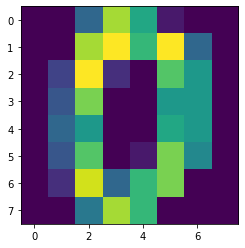

In [14]:
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
digits = load_digits()

X = digits.images
# Normalize the data so that all features lie in (0, 1)
X /= np.max(X)
y = digits.target
plt.imshow(X[0])
print(f'Sample image with label {y[0]}')
print(X.shape)

# Reshape input
X = X.reshape(-1, 64)
# Input size
isize = X.shape[-1]
# Output size
osize = len(np.unique(y))

In [15]:
def onehot_encoder(y):
    k = len(np.unique(y))
    return np.eye(k)[y]

In [16]:
from sklearn.model_selection import train_test_split
# random_state has the same seed value as rng

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=seed)
Y_train = onehot_encoder(y_train)
Y_test = onehot_encoder(y_test)

print('Training data shape:', X_train.shape, Y_train.shape)
print('Testing data shape:', X_test.shape, Y_test.shape)

Training data shape: (1078, 64) (1078, 10)
Testing data shape: (719, 64) (719, 10)


Test-data size = 719
Accuracy = 96.24
Number of parameters = 2410


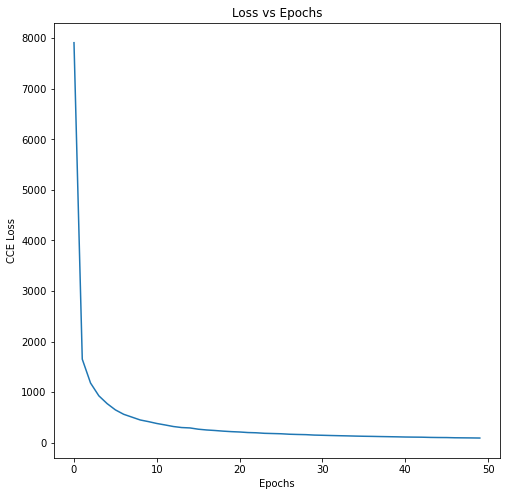

In [17]:
# Initialize the network
layers = [isize, 32, osize]
network = Network(layers, activation_choice='sigmoid', output_choice='softmax', loss_choice='cce')

# Fit the network on the data
epochs = 50
network.fit(X_train, Y_train, lr=0.01, epochs=epochs, batch_size=10)

# Plot the losses
plt.figure(figsize=(8,8))
plt.plot(range(epochs), network.losses)
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('CCE Loss')

# Compute the accuracy
accuracy = np.sum(network.predict(X_test) == y_test) /X_test.shape[0] * 100
print(f'Test-data size = {X_test.shape[0]}')
print(f'Accuracy = {accuracy:.2f}')
print(f'Number of parameters = {count_params(layers)}')